In [34]:
import pandas as pd
import numpy as np

def getData(filename):
  canData=[] #List to store CAN data
  f = open(filename)
  #read_file = reader(f)
  read_file =f.readlines()

  #file = list(read_file)
  speed = []
  rpm = []
  i = 0
  for row in read_file:
    #Change the positions of the values if needed
    record = {'stamp':row[1:18], 'PID':row[25:28], 'const1':row[29:33],
'change':row[33:41],'value':int(row[41:45], 16), 'value2':0 ,'attack':0}

    if record["PID"] == '254': #Processing of speed
      if record["value"] >= 4095:
        record["attack"] = 1
      record['value'] =  (record['value'] * 0.62137119) /100
      speed.append(record['value'])

    if record["PID"] == '115': #Processing of RPM
      if record["value"] >= 65535:
        record["attack"] = 1
      record['value'] =  (record['value'] * 2)
      rpm.append(record['value'])

    i = i+1
    canData.append(record)
    record={}

  f.close()
  return canData

def dict_to_df(dict):

  #load dictionary to dataframe
  df = pd.DataFrame.from_dict(dict)
  df = df.drop(columns=['stamp','const1','change','value2'])
  df = df.loc[(df['PID'] == '115') | (df['PID'] == '254')]
  df = df.reset_index(drop=True)
  one_hot = pd.get_dummies(df['PID'])
  df = df.drop('PID',axis = 1)
  df = df.join(one_hot)
  df = df[['115', '254', 'value', 'attack']]
  df.rename(columns = {'115':'RPM', '254':'Speed'}, inplace = True)
  df.loc[df['RPM'] == 1, 'RPM'] = df['value']
  df.loc[df['Speed'] == 1, 'Speed'] = df['value']
  df = df.drop(columns=['value'])

  return df

#edit file name with file directory of downloaded log files
fff_injection_df = dict_to_df(getData("/content/CAN Bus log - injection of FFF as the speed reading.log"))
rpm_injection_df = dict_to_df(getData("/content/CAN Bus log - injection of RPM readings.log"))
no_injection_df = dict_to_df(getData("/content/CAN bus log - no injection of messages.log"))
print(fff_injection_df)

         RPM      Speed  attack
0      626.0   0.000000       0
1        0.0   0.000000       0
2      624.0   0.000000       0
3        0.0   0.000000       0
4      624.0   0.000000       0
...      ...        ...     ...
14430    0.0   5.486708       0
14431    0.0  25.445150       1
14432    0.0  25.445150       1
14433  906.0   0.000000       0
14434    0.0  25.445150       1

[14435 rows x 3 columns]


In [35]:
print(rpm_injection_df )

           RPM     Speed  attack
0        740.0  0.000000       0
1          0.0  5.312724       0
2        742.0  0.000000       0
3          0.0  5.312724       0
4        744.0  0.000000       0
...        ...       ...     ...
4538       0.0  7.928696       0
4539  131070.0  0.000000       1
4540     882.0  0.000000       0
4541  131070.0  0.000000       1
4542  131070.0  0.000000       1

[4543 rows x 3 columns]


In [36]:
no_injection_df

,RPM,Speed,attack
0,636.0,0.000000,0
1,0.0,0.000000,0
2,640.0,0.000000,0
3,0.0,0.000000,0
4,640.0,0.000000,0
...,...,...,...
1644,702.0,0.000000,0
1645,702.0,0.000000,0
1646,0.0,3.038505,0
1647,702.0,0.000000,0


In [38]:
# Assuming canData is a list of dictionaries as in your initial code
canData_fff = getData("/content/CAN Bus log - injection of FFF as the speed reading.log")
canData_rpm = getData("/content/CAN Bus log - injection of RPM readings.log")
canData_no_injection = getData("/content/CAN bus log - no injection of messages.log")

# Convert the list of dictionaries to DataFrames
fff_injection_df = pd.DataFrame(canData_fff)
rpm_injection_df = pd.DataFrame(canData_rpm)
no_injection_df = pd.DataFrame(canData_no_injection)

# Print the first few rows of the DataFrame to inspect its structure
print(fff_injection_df.head())

               stamp  PID const1    change    value  value2  attack
0  1522028465.309906  264   0003  848C0100  32118.0       0       0
1  1522028465.310141  342   0027  073F0E00  14789.0       0       0
2  1522028465.310396  344   A5A1  B1A8459C  16384.0       0       0
3  1522028465.310662  40A   C102  39393738  12544.0       0       0
4  1522028465.310916  262   0800  08003253  40394.0       0       0


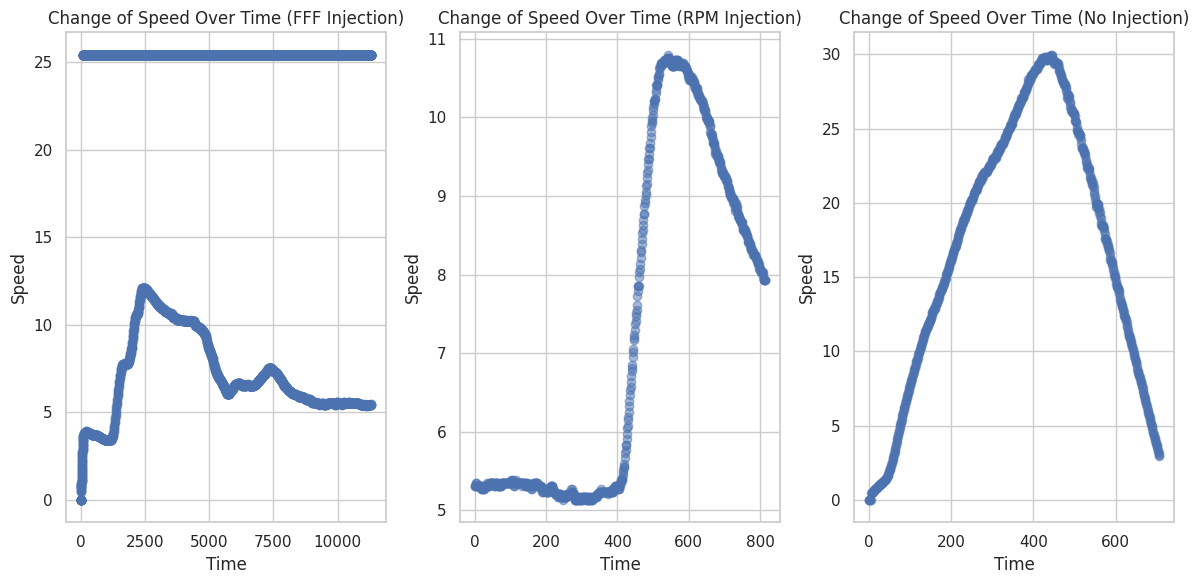

In [39]:
import matplotlib.pyplot as plt

# Filter data for speed readings (CAN ID 254)
speed_data_fff = fff_injection_df[fff_injection_df['PID'] == '254']['value']
speed_data_rpm = rpm_injection_df[rpm_injection_df['PID'] == '254']['value']
speed_data_no_injection = no_injection_df[no_injection_df['PID'] == '254']['value']

# Create time index (assuming the index of the data represents time)
time_index_fff = range(len(speed_data_fff))
time_index_rpm = range(len(speed_data_rpm))
time_index_no_injection = range(len(speed_data_no_injection))

# Plot change of speed over time for each scenario
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.scatter(time_index_fff, speed_data_fff, alpha=0.5)
plt.title('Change of Speed Over Time (FFF Injection)')
plt.xlabel('Time')
plt.ylabel('Speed')

plt.subplot(132)
plt.scatter(time_index_rpm, speed_data_rpm, alpha=0.5)
plt.title('Change of Speed Over Time (RPM Injection)')
plt.xlabel('Time')
plt.ylabel('Speed')

plt.subplot(133)
plt.scatter(time_index_no_injection, speed_data_no_injection, alpha=0.5)
plt.title('Change of Speed Over Time (No Injection)')
plt.xlabel('Time')
plt.ylabel('Speed')

plt.tight_layout()
plt.show()

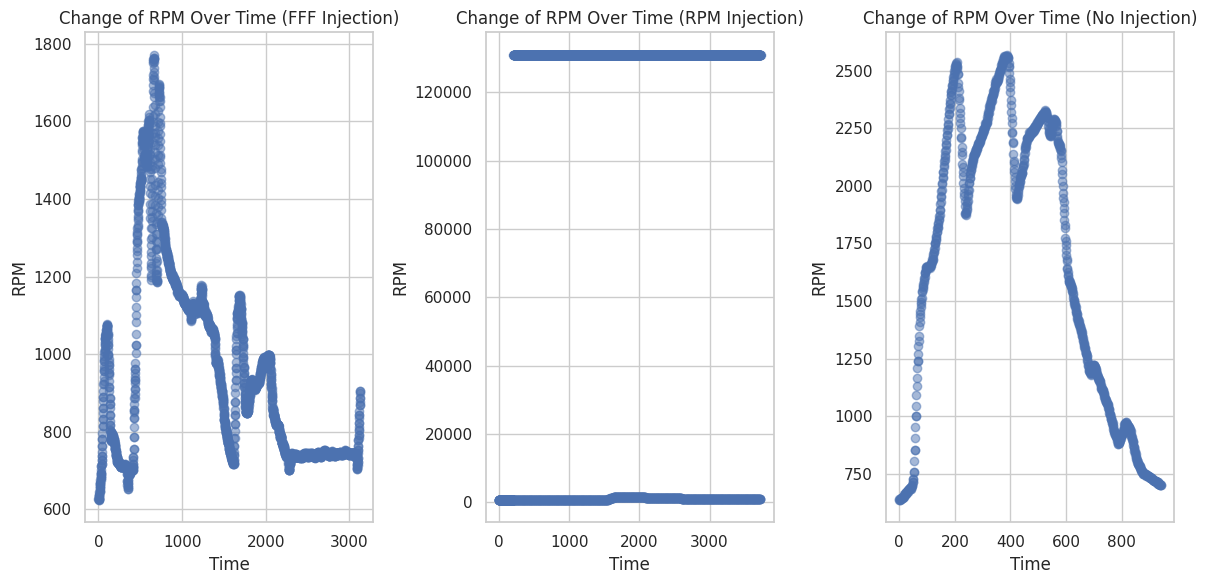

In [40]:
import matplotlib.pyplot as plt

# Filter data for RPM readings (CAN ID 115)
rpm_data_fff = fff_injection_df[fff_injection_df['PID'] == '115']['value']
rpm_data_rpm = rpm_injection_df[rpm_injection_df['PID'] == '115']['value']
rpm_data_no_injection = no_injection_df[no_injection_df['PID'] == '115']['value']

# Create time index (assuming the index of the data represents time)
time_index_fff = range(len(rpm_data_fff))
time_index_rpm = range(len(rpm_data_rpm))
time_index_no_injection = range(len(rpm_data_no_injection))

# Plot change of RPM over time for each scenario
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.scatter(time_index_fff, rpm_data_fff, alpha=0.5)
plt.title('Change of RPM Over Time (FFF Injection)')
plt.xlabel('Time')
plt.ylabel('RPM')

plt.subplot(132)
plt.scatter(time_index_rpm, rpm_data_rpm, alpha=0.5)
plt.title('Change of RPM Over Time (RPM Injection)')
plt.xlabel('Time')
plt.ylabel('RPM')

plt.subplot(133)
plt.scatter(time_index_no_injection, rpm_data_no_injection, alpha=0.5)
plt.title('Change of RPM Over Time (No Injection)')
plt.xlabel('Time')
plt.ylabel('RPM')

plt.tight_layout()
plt.show()

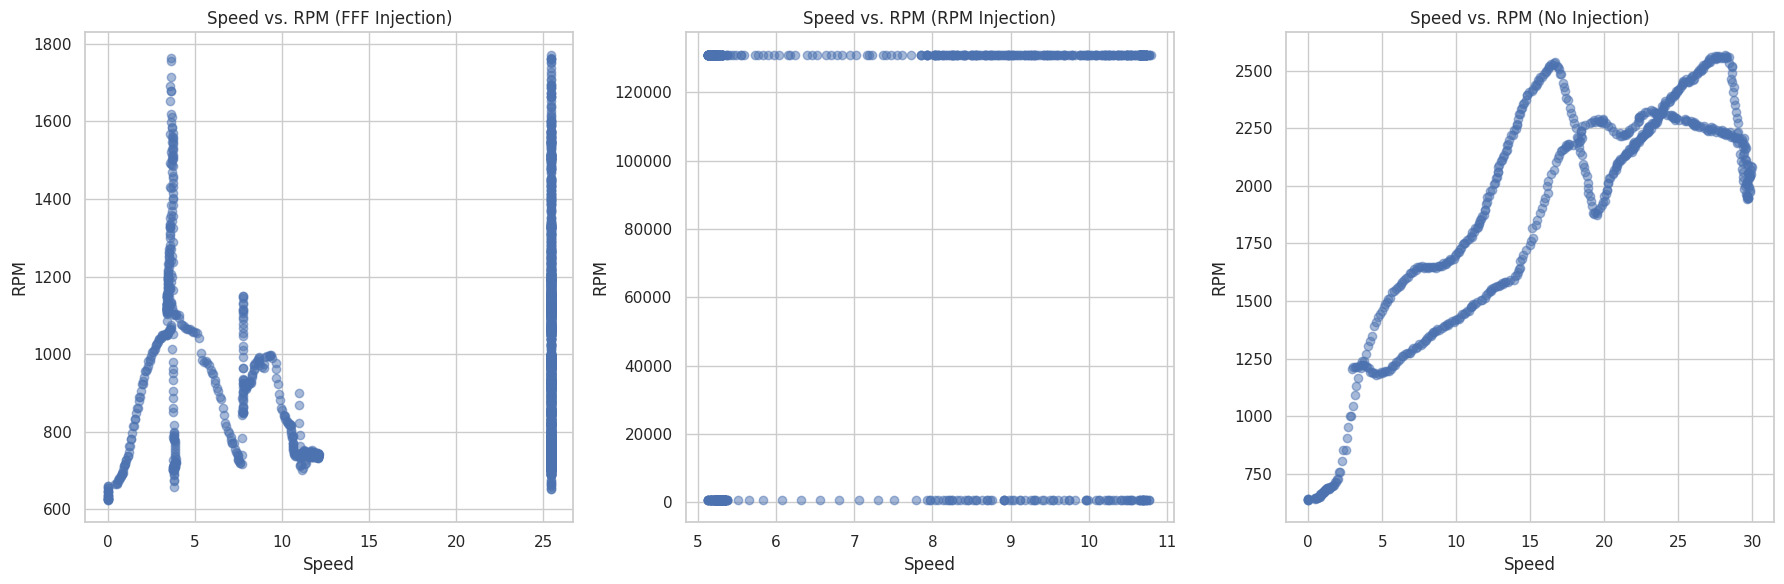

In [41]:
import matplotlib.pyplot as plt

# Filter data for speed readings (CAN ID 254) and RPM readings (CAN ID 115) for each scenario
speed_data_fff = fff_injection_df[fff_injection_df['PID'] == '254']['value']
rpm_data_fff = fff_injection_df[fff_injection_df['PID'] == '115']['value']

speed_data_rpm = rpm_injection_df[rpm_injection_df['PID'] == '254']['value']
rpm_data_rpm = rpm_injection_df[rpm_injection_df['PID'] == '115']['value']

speed_data_no_injection = no_injection_df[no_injection_df['PID'] == '254']['value']
rpm_data_no_injection = no_injection_df[no_injection_df['PID'] == '115']['value']

# Ensure that the lengths of speed and RPM data match for each scenario
min_length_fff = min(len(speed_data_fff), len(rpm_data_fff))
speed_data_fff = speed_data_fff[:min_length_fff]
rpm_data_fff = rpm_data_fff[:min_length_fff]

min_length_rpm = min(len(speed_data_rpm), len(rpm_data_rpm))
speed_data_rpm = speed_data_rpm[:min_length_rpm]
rpm_data_rpm = rpm_data_rpm[:min_length_rpm]

min_length_no_injection = min(len(speed_data_no_injection), len(rpm_data_no_injection))
speed_data_no_injection = speed_data_no_injection[:min_length_no_injection]
rpm_data_no_injection = rpm_data_no_injection[:min_length_no_injection]

# Create scatter plots for the relationship between speed and RPM for each scenario
plt.figure(figsize=(18, 6))

# FFF Injection Scenario
plt.subplot(131)
plt.scatter(speed_data_fff, rpm_data_fff, alpha=0.5)
plt.title('Speed vs. RPM (FFF Injection)')
plt.xlabel('Speed')
plt.ylabel('RPM')
plt.grid(True)

# RPM Injection Scenario
plt.subplot(132)
plt.scatter(speed_data_rpm, rpm_data_rpm, alpha=0.5)
plt.title('Speed vs. RPM (RPM Injection)')
plt.xlabel('Speed')
plt.ylabel('RPM')
plt.grid(True)

# No Injection Scenario
plt.subplot(133)
plt.scatter(speed_data_no_injection, rpm_data_no_injection, alpha=0.5)
plt.title('Speed vs. RPM (No Injection)')
plt.xlabel('Speed')
plt.ylabel('RPM')
plt.grid(True)

plt.tight_layout()
plt.show()

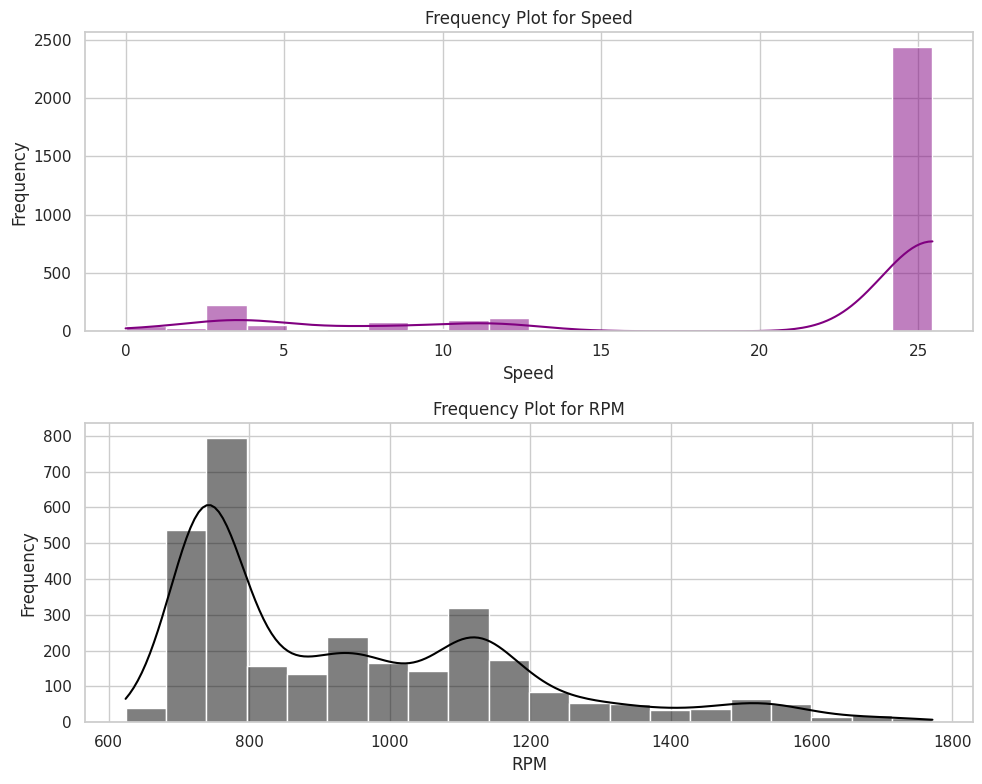

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the plots
sns.set(style="whitegrid")

# Create subplots for speed and RPM
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Frequency Plot for Speed
sns.histplot(speed_data_fff, bins=20, kde=True, color='purple', ax=axes[0])
axes[0].set_title('Frequency Plot for Speed')
axes[0].set_xlabel('Speed')
axes[0].set_ylabel('Frequency')

# Frequency Plot for RPM
sns.histplot(rpm_data_fff, bins=20, kde=True, color='black', ax=axes[1])
axes[1].set_title('Frequency Plot for RPM')
axes[1].set_xlabel('RPM')
axes[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [43]:
import pandas as pd
import numpy as np
def getData(filename):
  canData=[] #List to store CAN data
  f = open(filename)
  #read_file = reader(f)
  read_file =f.readlines()

  #file = list(read_file)
  speed = []
  rpm = []
  i = 0
  for row in read_file:
    #Change the positions of the values if needed
    record = {'stamp':row[1:18], 'PID':row[25:28], 'const1':row[29:33],
'change':row[33:41],'value':int(row[41:45], 16), 'value2':0 ,'attack':0}

    if record["PID"] == '254': #Processing of speed
      if record["value"] >= 4095:
        record["attack"] = 1
      record['value'] =  (record['value'] * 0.62137119) /100
      speed.append(record['value'])

    if record["PID"] == '115': #Processing of RPM
      if record["value"] >= 65535:
        record["attack"] = 1
      record['value'] =  (record['value'] * 2)
      rpm.append(record['value'])

    i = i+1
    canData.append(record)
    record={}

  f.close()
  return canData

def dict_to_df(dict):

  #load dictionary to dataframe
  df = pd.DataFrame.from_dict(dict)
  df = df.drop(columns=['stamp','const1','change','value2'])
  df = df.loc[(df['PID'] == '115') | (df['PID'] == '254')]
  df = df.reset_index(drop=True)
  one_hot = pd.get_dummies(df['PID'])
  df = df.drop('PID',axis = 1)
  df = df.join(one_hot)
  df = df[['115', '254', 'value', 'attack']]
  df.rename(columns = {'115':'RPM', '254':'Speed'}, inplace = True)
  df.loc[df['RPM'] == 1, 'RPM'] = df['value']
  df.loc[df['Speed'] == 1, 'Speed'] = df['value']
  df = df.drop(columns=['value'])

  return df

#edit file name with file directory of downloaded log files
fff_injection_df = dict_to_df(getData("/content/CAN Bus log - injection of FFF as the speed reading.log"))
rpm_injection_df = dict_to_df(getData("/content/CAN Bus log - injection of RPM readings.log"))
no_injection_df = dict_to_df(getData("/content/CAN bus log - no injection of messages.log"))
print(fff_injection_df)

         RPM      Speed  attack
0      626.0   0.000000       0
1        0.0   0.000000       0
2      624.0   0.000000       0
3        0.0   0.000000       0
4      624.0   0.000000       0
...      ...        ...     ...
14430    0.0   5.486708       0
14431    0.0  25.445150       1
14432    0.0  25.445150       1
14433  906.0   0.000000       0
14434    0.0  25.445150       1

[14435 rows x 3 columns]


In [44]:
from scipy.stats import pearsonr
import pandas as pd

# Calculate Pearson correlation and p-value for each scenario
correlation_fff, p_value_fff = pearsonr(speed_data_fff, rpm_data_fff)
correlation_rpm, p_value_rpm = pearsonr(speed_data_rpm, rpm_data_rpm)
correlation_no_injection, p_value_no_injection = pearsonr(speed_data_no_injection, rpm_data_no_injection)

# Create a correlation table
correlation_data = {
    'Scenario': ['FFF Injection', 'RPM Injection', 'No Injection'],
    'Correlation Coefficient': [correlation_fff, correlation_rpm, correlation_no_injection],
    'P-Value': [p_value_fff, p_value_rpm, p_value_no_injection]
}

correlation_df = pd.DataFrame(correlation_data)

# Display the correlation table
print(correlation_df)

        Scenario  Correlation Coefficient        P-Value
0  FFF Injection                -0.013449   4.520206e-01
1  RPM Injection                 0.334291   9.374616e-23
2   No Injection                 0.856226  2.085636e-204


In [54]:
import pandas as pd

# Assuming you have three datasets: fff_injection_df, rpm_injection_df, and no_injection_df

# Combine the datasets using concat
combined_df = pd.concat([fff_injection_df, rpm_injection_df, no_injection_df])

# Reset the index if needed
combined_df.reset_index(drop=True, inplace=True)
combined_df

# Now, combined_df contains all the data from the three datasets


,RPM,Speed,attack
0,626.0,0.000000,0
1,0.0,0.000000,0
2,624.0,0.000000,0
3,0.0,0.000000,0
4,624.0,0.000000,0
...,...,...,...
20622,702.0,0.000000,0
20623,702.0,0.000000,0
20624,0.0,3.038505,0
20625,702.0,0.000000,0


In [55]:
from sklearn.model_selection import train_test_split

# Specify the features (X) and target (y)
X = combined_df.drop(columns=['attack'])  # Features (all columns except 'Attack')
y = combined_df['attack']  # Target (the 'Attack' column)

# Split the dataset into 3/4 training and 1/4 testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [56]:
# Example with a Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

# Create an instance of the model
clf = RandomForestClassifier()

# Train the model on the training data
clf.fit(X_train, y_train)

RandomForestClassifier()

In [58]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Assuming you have already trained your model and have X_test and y_test ready

# Predict on the test data
y_pred = clf.predict(X_test)  # Replace 'clf' with your trained model

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" %(accuracy*100.0))

# Create a confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(confusion)

# Generate a classification report
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

Accuracy: 100.00%
Confusion Matrix:
[[2212    0]
 [   0 2945]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2212
           1       1.00      1.00      1.00      2945

    accuracy                           1.00      5157
   macro avg       1.00      1.00      1.00      5157
weighted avg       1.00      1.00      1.00      5157



In [59]:
from sklearn.svm import SVC

# Create an instance of the SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)

# Train the SVM model on the training data
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [57]:
# Import necessary libraries
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Combine the three datasets into one large dataset (assuming you have a DataFrame named 'combined_df')
# Replace 'combined_df' with your actual combined dataset
# Example: combined_df = pd.concat([data_fff, data_rpm, data_no_injection], axis=0)

# Specify the features (X) and target (y)
X = combined_df.drop(columns=['attack'])  # Features (all columns except 'Attack')
y = combined_df['attack']  # Target (the 'Attack' column)

# Split the dataset into 3/4 training and 1/4 testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create an instance of the Support Vector Machine (SVM) classifier
clf = SVC(kernel='linear', random_state=42)

# Train the model on the training data
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Create a confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(confusion)

# Generate a classification report
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

Accuracy: 100.00%
Confusion Matrix:
[[2212    0]
 [   0 2945]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2212
           1       1.00      1.00      1.00      2945

    accuracy                           1.00      5157
   macro avg       1.00      1.00      1.00      5157
weighted avg       1.00      1.00      1.00      5157



Task 5

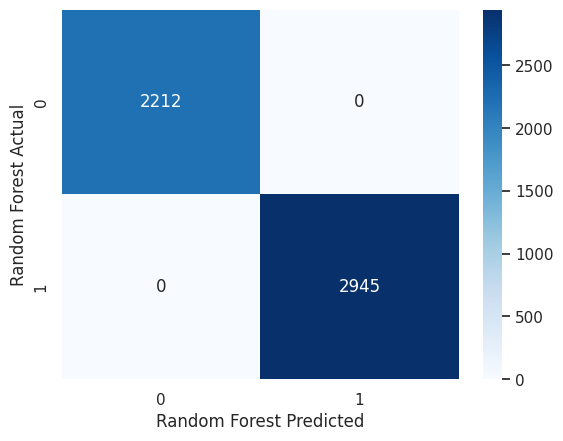

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are your actual test labels and predicted labels for Random Forest
cm_rf = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Random Forest Predicted")
plt.ylabel("Random Forest Actual")
plt.show()

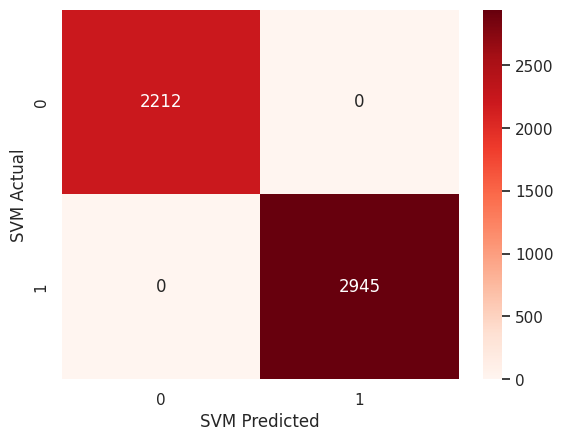

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are your actual test labels and predicted labels for SVM
cm_svm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap="Reds")
plt.xlabel("SVM Predicted")
plt.ylabel("SVM Actual")
plt.show()